<a href="https://colab.research.google.com/github/Daivar/Deep_Learning_Models/blob/main/Number_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
!rm -rf ./datasets/images/

!wget -q --directory-prefix='datasets/mnist-in-csv/' https://github.com/MindaugasBernatavicius/DeepLearningCourse/raw/master/07_Computer_Vision_Image_Classification/datasets/mnist-in-csv/mnist_test.csv
!wget -q --directory-prefix='datasets/mnist-in-csv/' https://github.com/MindaugasBernatavicius/DeepLearningCourse/raw/master/07_Computer_Vision_Image_Classification/datasets/mnist-in-csv/mnist_train.csv

mnist_train = pd.read_csv('datasets/mnist-in-csv/mnist_train.csv')
mnist_test = pd.read_csv('datasets/mnist-in-csv/mnist_test.csv')

In [4]:
mnist_train = mnist_train.dropna()
mnist_test = mnist_test.dropna()

mnist_train_features = mnist_train.drop('label', axis =1)
mnist_train_target = mnist_train['label']
mnist_test_features = mnist_test.drop('label', axis =1)
mnist_test_target = mnist_test['label']

X_train_tensor = torch.tensor(mnist_train_features.values, dtype=torch.float)
x_test_tensor  = torch.tensor(mnist_test_features.values, dtype=torch.float) 
Y_train_tensor = torch.tensor(mnist_train_target.values, dtype=torch.long)
y_test_tensor  = torch.tensor(mnist_test_target.values, dtype=torch.long)

X_train_tensor = X_train_tensor.reshape(-1, 1, 28, 28)
x_test_tensor = x_test_tensor.reshape(-1, 1, 28, 28)

in_size = 1 # channel size
hid1_size = 32 #Re-run for 32
hid2_size = 32 #Re-run for 64
out_size = 10 # categories
k_conv_size = 5 # size of kernel
p_kern_size = 2
batch_size = 128
ll_in_size = 512 # 256 --> RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x512 and 256x10)

class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_size, hid1_size, k_conv_size),
      nn.BatchNorm2d(hid1_size),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=p_kern_size)
    )
    self.layer2 = nn.Sequential(
      nn.Conv2d(hid1_size, hid2_size, k_conv_size),
      nn.BatchNorm2d(hid2_size),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=p_kern_size),
      nn.Flatten()
    )
    self.fc = nn.Linear(ll_in_size, out_size)
 
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    # out = out.reshape(out.size(0), -1) # you either reshape or need nn.Flatten()
    out = self.fc(out)
    return out
    # return F.log_softmax(out, dim=-1) # we will use this latter


model = ConvNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

X_train_tensor = X_train_tensor.to(device)
x_test_tensor  = x_test_tensor.to(device) 
Y_train_tensor = Y_train_tensor.to(device)
y_test_tensor  = y_test_tensor.to(device)
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

learning_rate = 0.001 
criterion = nn.CrossEntropyLoss()
# criterion = #nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) 

num_epochs = 10
loss_values = list()

for epoch in range(1, num_epochs):
  for x, y in train_loader:
    outputs = model(x)
    loss = criterion(outputs, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())  
  print('Epoch - %d, loss - %0.5f '%(epoch, loss.item())) 
  # loss_values.append(loss.item())

Epoch - 1, loss - 0.06076 
Epoch - 2, loss - 0.04218 
Epoch - 3, loss - 0.02716 
Epoch - 4, loss - 0.01756 
Epoch - 5, loss - 0.01009 
Epoch - 6, loss - 0.00796 
Epoch - 7, loss - 0.00646 
Epoch - 8, loss - 0.00622 
Epoch - 9, loss - 0.00280 


Text(0, 0.5, 'Loss')

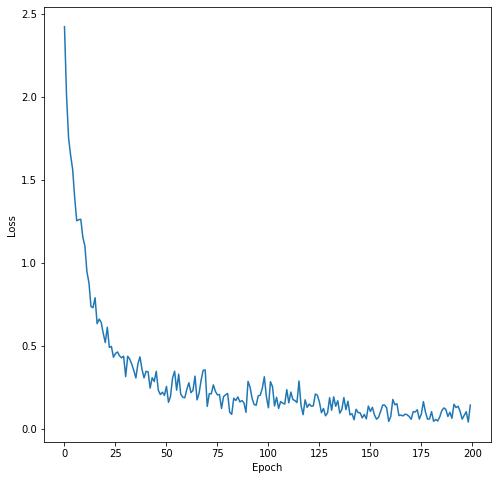

In [5]:
portion_size = 200
x = (range(0, len(loss_values[:portion_size])))

plt.figure(figsize = (8, 8))
plt.plot(x, loss_values[:portion_size])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [9]:
!wget -q --directory-prefix='./' https://github.com/MindaugasBernatavicius/DeepLearningCourse/raw/master/07_Computer_Vision_Image_Classification/datasets/cust_img_of_3.jpg
# !wget -q --directory-prefix='./' https://github.com/MindaugasBernatavicius/DeepLearningCourse/raw/master/07_Computer_Vision_Image_Classification/datasets/cust_img_of_1.jpg

tensor([[ -7.1044, -10.3320,  -7.5263,   6.1669,  -8.0177,  -2.6964, -12.9075,
          -9.2382,  -8.1173,  -3.7322]], grad_fn=<AddmmBackward0>)
The predicted label is :  3


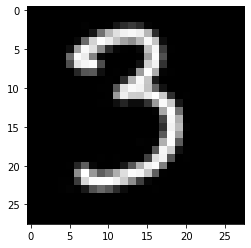

In [10]:
import PIL.ImageOps
from PIL import Image, ImageEnhance 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import skimage.transform
import skimage.io
from skimage import data

def increase_whites_by_threshold(img, threshold):
  if type(img) is not np.ndarray:
    img = np.array(img)
  for line in range(0, len(img)):
    for pixel in range(0, len(img[line])):
      img[line][pixel] = 1 if img[line][pixel] > threshold else 0
  return img

i = "cust_img_of_3.jpg"
i = Image.open(i)


i = i.resize((28, 28))
i = PIL.ImageOps.invert(i)
# enhancer = ImageEnhance.Contrast(i)
# i = enhancer.enhance(1.5) # 0.9
i = skimage.color.rgb2gray(np.asarray(i))
# i = increase_whites_by_threshold(i, 0.7)

if type(i) is not np.ndarray:
  i = np.array(i)

plt.imshow(i, cmap='gray')

image_t = torch.from_numpy(i).float()
image_t = image_t.reshape(-1, 1, 28, 28)
image_t = image_t.to(device)

y_pred = model(image_t)
print(y_pred)
_, predicted = torch.max(y_pred.data, -1)
print("The predicted label is : ", predicted.item())